In [1]:
from Data import *

import pandas as pd
import string
import random

import torch
from torch import optim
import torch.nn.functional as F
import torch.nn as nn
from torch.nn.utils.rnn import  pack_padded_sequence, pad_packed_sequence
from torchsummary import summary

import matplotlib.pyplot as plt
# plt.switch_backend('agg')
import numpy as np
import tqdm
from nltk.translate.bleu_score import SmoothingFunction, sentence_bleu

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
checkpoint_name = 'Lab4_seq2seq_vae_gru.pt'
print('Using {} device'.format(device))

Using cuda device


In [2]:
sp = 0
tp = 1
pg = 2
p = 3

def split_data(data):
    split_data = []
    for string in data:
        split_space = string.split()
        for i, word in enumerate(split_space):
            split_data.append(word)
    return split_data

def y_train_make(n):
    np_sp = np.array([sp])
    np_tp = np.array([tp])
    np_pg = np.array([pg])
    np_p = np.array([p])
    y = []
    for i in range(n):
        y.append(np_sp)
        y.append(np_tp)
        y.append(np_pg)
        y.append(np_p)
    return np.array(y)

def src_trg_split(data):
    src = []
    trg = []
    for i in range(0, len(data), 2):
        src.append(data[i])
        trg.append(data[i])
    return np.array(src), np.array(trg)

In [3]:
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

train_data = np.squeeze(pd.read_csv('train.txt', header=None))
y_train = y_train_make(len(train_data))

train_data = split_data(train_data)

vocab = Vocabulary()
vocab.build_vocab(train_data)

train_loader = DataTransformer(train_data, use_cuda=True)

In [4]:
test_data = np.squeeze(pd.read_csv('test.txt', header=None))
test_data = split_data(test_data)
test_data = np.array(test_data)
src, trg = src_trg_split(test_data)
test_src = []
test_trg = []

for word in src:
    test_src.append(train_loader.vocab.sequence_to_indices(word, add_eos=True))

for word in trg:
    test_trg.append(train_loader.vocab.sequence_to_indices(word, add_eos=True))
"""
sp -> p
sp -> pg
sp -> tp
sp -> tp
p  -> tp
sp -> pg
p  -> sp
pg -> sp
pg -> p
pg -> tp
"""
test_c_src = np.array([sp, sp, sp, sp, p, sp, p, pg, pg, pg]).reshape(-1, 1)
test_c_trg = np.array([p, pg, tp, tp, tp, pg, sp, sp, p, tp]).reshape(-1, 1)
test_c_src = torch.tensor(test_c_src).to(device)
test_c_trg = torch.tensor(test_c_trg).to(device)

In [5]:
def test_eval(model, epoch):
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():    
        src_c = test_src
        trg_c = test_trg
        optimizer.zero_grad()            
        output = model(src, trg, src_c, trg_c, 0) #turn off teacher forcing
        loss = criterion(output[1:].view(-1, output.shape[-1]), trg[1:].view(-1))
        
        if epoch % 10 == 0:
            print("=========show testing result=========")
            for i in range(output.shape[-1]):
                show_result(trg, output, i)
                print()
            
        return loss
    
def show_result(target, output, index):
    print("Ground true: ", end="")
    for i in range(max_len):
        tmp = trg[index, i]
        if tmp == 1:
            break
        elif tmp == 0:
            continue
        print(chr(trg[index, i]-7+ord('a')), end="")
    
    print(" Predict: ", end="")
    for i in range(max_len):
        print(chr(np.argmax(o[index, i, 3:])-4+ord('a')), end="")

In [6]:
class Encoder(nn.Module):

    def __init__(self, vocab_size, embedding_size, output_size, lat_dim):
        """Define layers for a vanilla rnn encoder"""
        super(Encoder, self).__init__()

        self.vocab_size = vocab_size
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.gru = nn.GRU(embedding_size, output_size)
        
        self.hidden2mean = nn.Linear(output_size, lat_dim)
        self.hidden2logv = nn.Linear(output_size, lat_dim)

    def forward(self, input_seqs, input_lengths, hidden=None):
        embedded = self.embedding(input_seqs)
        packed = pack_padded_sequence(embedded, input_lengths)
        packed_outputs, hidden = self.gru(packed, hidden)
        outputs, output_lengths = pad_packed_sequence(packed_outputs)
        
        means = self.hidden2mean(hidden)
        logv = self.hidden2logv(hidden)
        
        return outputs, means, logv

In [7]:
class Decoder(nn.Module):

    def __init__(self, hidden_size, output_size, lat_dim, max_length, teacher_forcing_ratio, sos_id, use_cuda):
        """Define layers for a vanilla rnn decoder"""
        super(Decoder, self).__init__()

        self.hidden_size = hidden_size
        self.output_size = output_size
        self.latent2hidden = nn.Linear(lat_dim, hidden_size)
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.log_softmax = nn.LogSoftmax(dim=-1)  # work with NLLLoss = CrossEntropyLoss

        self.max_length = max_length
        self.teacher_forcing_ratio = teacher_forcing_ratio
        self.sos_id = sos_id
        self.use_cuda = use_cuda

    def forward_step(self, inputs, hidden):
        # inputs: (time_steps=1, batch_size)
        batch_size = inputs.size(1)
        embedded = self.embedding(inputs)
        embedded.view(1, batch_size, self.hidden_size)  # S = T(1) x B x N
        rnn_output, hidden = self.gru(embedded, hidden)  # S = T(1) x B x H
        rnn_output = rnn_output.squeeze(0)  # squeeze the time dimension
        output = self.log_softmax(self.out(rnn_output))  # S = B x O
        return output, hidden

    def forward(self, context_vector, targets):

        # Prepare variable for decoder on time_step_0
        target_vars, target_lengths = targets
        batch_size = context_vector.size(1)
        decoder_input = Variable(torch.LongTensor([[self.sos_id] * batch_size]))

        # Pass the context vector
        decoder_hidden = context_vector

        max_target_length = max(target_lengths)
        decoder_outputs = Variable(torch.zeros(
            max_target_length,
            batch_size,
            self.output_size
        ))  # (time_steps, batch_size, vocab_size)

        if self.use_cuda:
            decoder_input = decoder_input.cuda()
            decoder_outputs = decoder_outputs.cuda()

        use_teacher_forcing = True if random.random() < self.teacher_forcing_ratio else False

        # Unfold the decoder RNN on the time dimension
        for t in range(max_target_length):
            decoder_outputs_on_t, decoder_hidden = self.forward_step(decoder_input, decoder_hidden)
            decoder_outputs[t] = decoder_outputs_on_t
            if use_teacher_forcing:
                decoder_input = target_vars[t].unsqueeze(0)
            else:
                decoder_input = self._decode_to_index(decoder_outputs_on_t)

        return decoder_outputs, decoder_hidden

    def evaluate(self, context_vector):
        batch_size = context_vector.size(1) # get the batch size
        decoder_input = Variable(torch.LongTensor([[self.sos_id] * batch_size]))
        decoder_hidden = context_vector

        decoder_outputs = Variable(torch.zeros(
            self.max_length,
            batch_size,
            self.output_size
        ))  # (time_steps, batch_size, vocab_size)

        if self.use_cuda:
            decoder_input = decoder_input.cuda()
            decoder_outputs = decoder_outputs.cuda()

        # Unfold the decoder RNN on the time dimension
        for t in range(self.max_length):
            decoder_outputs_on_t, decoder_hidden = self.forward_step(decoder_input, decoder_hidden)
            decoder_outputs[t] = decoder_outputs_on_t
            decoder_input = self._decode_to_index(decoder_outputs_on_t)  # select the former output as input

        return self._decode_to_indices(decoder_outputs)

    def _decode_to_index(self, decoder_output):
        """
        evaluate on the logits, get the index of top1
        :param decoder_output: S = B x V or T x V
        """
        value, index = torch.topk(decoder_output, 1)
        index = index.transpose(0, 1)  # S = 1 x B, 1 is the index of top1 class
        if self.use_cuda:
            index = index.cuda()
        return index

    def _decode_to_indices(self, decoder_outputs):
        """
        Evaluate on the decoder outputs(logits), find the top 1 indices.
        Please confirm that the model is on evaluation mode if dropout/batch_norm layers have been added
        :param decoder_outputs: the output sequence from decoder, shape = T x B x V 
        """
        decoded_indices = []
        batch_size = decoder_outputs.size(1)
        decoder_outputs = decoder_outputs.transpose(0, 1)  # S = B x T x V

        for b in range(batch_size):
            top_ids = self._decode_to_index(decoder_outputs[b])
            decoded_indices.append(top_ids.data[0].cpu().numpy())
        return decoded_indices

In [8]:
class Seq2Seq(nn.Module):

    def __init__(self, encoder, decoder):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, inputs, targets):
        input_vars, input_lengths = inputs
        encoder_outputs, encoder_means, encoder_logv = self.encoder.forward(input_vars, input_lengths)        
        encoder_hidden = self.reparaterization_trick(encoder_means, encoder_logv)
        encoder_hidden = self.decoder.latent2hidden(encoder_hidden)
        decoder_outputs, decoder_hidden = self.decoder.forward(context_vector=encoder_hidden, targets=targets)
        return decoder_outputs, decoder_hidden

    def evaluate(self, inputs):
        input_vars, input_lengths = inputs
        encoder_outputs, encoder_means, encoder_logv = self.encoder(input_vars, input_lengths)
        encoder_hidden = self.reparaterization_trick(encoder_means, encoder_logv)
        encoder_hidden = self.decoder.latent2hidden(encoder_hidden)
        decoded_sentence = self.decoder.evaluate(context_vector=encoder_hidden)
        return decoded_sentence
    
    def reparaterization_trick(self, mean, logv):
        std = torch.exp(0.5*logv)
        eps = torch.randn_like(std)
        return  mean + eps * std

In [9]:
class Trainer(object):

    def __init__(self, model, data_transformer, learning_rate, use_cuda, checkpoint_name,
                 teacher_forcing_ratio=1.0):

        self.model = model
        self.checkpoint_name = checkpoint_name
        
        # save list
        self.loss_list = []
        self.score = []

        # record some information about dataset
        self.data_transformer = data_transformer
        self.vocab_size = self.data_transformer.vocab_size
        self.PAD_ID = self.data_transformer.PAD_ID
        self.use_cuda = use_cuda

        # optimizer setting
        self.learning_rate = learning_rate
        self.optimizer= torch.optim.Adam(self.model.parameters(), lr=learning_rate)
        self.criterion = torch.nn.NLLLoss(ignore_index=self.PAD_ID, reduction='mean')

    def train(self, num_epochs, batch_size, pretrained=False):

        if pretrained:
            self.load_model()

        step = 0

        for epoch in range(0, num_epochs):
            mini_batches = self.data_transformer.mini_batches(batch_size=batch_size)
            for input_batch, target_batch in mini_batches:
                self.optimizer.zero_grad()
                decoder_outputs, decoder_hidden = self.model(input_batch, target_batch)

                # calculate the loss and back prop.
                cur_loss = self.get_loss(decoder_outputs, target_batch[0])
                self.loss_list.append(cur_loss.item())
                
                # logging
                step += 1
                if step % 50 == 0:
                    print("Step:", step, "char-loss: ", cur_loss.detach().cpu().numpy())
                    self.save_model()
                cur_loss.backward()

                # optimize
                self.optimizer.step()

        self.save_model()

    def masked_nllloss(self):
        # Deprecated in PyTorch 2.0, can be replaced by ignore_index
        # define the masked NLLoss
        weight = torch.ones(self.vocab_size)
        weight[self.PAD_ID] = 0
        if self.use_cuda:
            weight = weight.cuda()
        return torch.nn.NLLLoss(weight=weight).cuda()

    def get_loss(self, decoder_outputs, targets):
        b = decoder_outputs.size(1)
        t = decoder_outputs.size(0)
        targets = targets.contiguous().view(-1)  # S = (B*T)
        decoder_outputs = decoder_outputs.view(b * t, -1)  # S = (B*T) x V
        return self.criterion(decoder_outputs, targets)

    def save_model(self):
        torch.save(self.model.state_dict(), self.checkpoint_name)
        np.savez('loss.npz', train_loss=self.loss_list, score=self.score)
        print("Model has been saved as %s.\n" % self.checkpoint_name)

    def load_model(self):
        self.model.load_state_dict(torch.load(self.checkpoint_name, map_location='cpu'))
        print("Pretrained model has been loaded.\n")

    def evaluate(self, words):
        # make sure that words is list
        if type(words) is not list:
            words = [words]

        # transform word to index-sequence
        eval_var = self.data_transformer.evaluation_batch(words=words)
        decoded_indices = self.model.evaluate(eval_var)
        results = []
        for indices in decoded_indices:
            results.append(self.data_transformer.vocab.indices_to_sequence(indices))
        return results
    
    def compute_bleu(self, output, reference):
        cc = SmoothingFunction()
        if len(reference) == 3:
            weights = (0.33,0.33,0.33)
        else:
            weights = (0.25,0.25,0.25,0.25)
        return sentence_bleu([reference], output,weights=weights,smoothing_function=cc.method1)

In [10]:
# define our models
encoder = Encoder(vocab_size=train_loader.vocab_size,
                         embedding_size=256,
                         output_size=256,
                         lat_dim=32).to(device)

decoder = Decoder(hidden_size=256,
                         output_size=train_loader.vocab_size,
                         lat_dim=32,
                         max_length=train_loader.max_length,
                         teacher_forcing_ratio=1.,
                         sos_id=train_loader.SOS_ID,
                         use_cuda=True).to(device)

seq2seq = Seq2Seq(encoder=encoder,
                  decoder=decoder)

trainer = Trainer(seq2seq, train_loader, learning_rate=0.001, use_cuda=True, checkpoint_name=checkpoint_name)

for epoch in range(10):
    trainer.train(num_epochs=10, batch_size=128, pretrained=False)
    
    ## eval
    print("======================Evaluating======================")  
    total_score = 0.0
    for src in test_src:
        word = vocab.indices_to_sequence(src)
        results = trainer.evaluate(word)[0]
        score = trainer.compute_bleu(results, word)
        print("True: {:>12}".format(word), "\tPredict: {:>12}".format(results), "\tScore: {:>8.5f}".format(score))
        total_score += score
    total_score /= len(test_src)
    trainer.score.append(total_score)
    print("======================================================\n")

Step: 50 char-loss:  2.3732402
Model has been saved as Lab4_seq2seq_vae_gru.pt.

Step: 100 char-loss:  1.9252355
Model has been saved as Lab4_seq2seq_vae_gru.pt.

Step: 150 char-loss:  1.5030504
Model has been saved as Lab4_seq2seq_vae_gru.pt.

Step: 200 char-loss:  1.2731693
Model has been saved as Lab4_seq2seq_vae_gru.pt.

Step: 250 char-loss:  1.133544
Model has been saved as Lab4_seq2seq_vae_gru.pt.

Step: 300 char-loss:  0.94207287
Model has been saved as Lab4_seq2seq_vae_gru.pt.

Step: 350 char-loss:  0.8997877
Model has been saved as Lab4_seq2seq_vae_gru.pt.

Model has been saved as Lab4_seq2seq_vae_gru.pt.

======================Evaluating======================
True:      abandon 	Predict: aaoondadnned 	Score:  0.05638
True:         abet 	Predict:    baataates 	Score:  0.03391
True:        begin 	Predict:   beginginng 	Score:  0.39281
True:       expend 	Predict:   expenndndd 	Score:  0.43472
True:         sent 	Predict:    snsesttns 	Score:  0.06031
True:        split 	Predict

Step: 150 char-loss:  0.00093418674
Model has been saved as Lab4_seq2seq_vae_gru.pt.

Step: 200 char-loss:  0.00093457237
Model has been saved as Lab4_seq2seq_vae_gru.pt.

Step: 250 char-loss:  0.00076817564
Model has been saved as Lab4_seq2seq_vae_gru.pt.

Step: 300 char-loss:  0.0006836713
Model has been saved as Lab4_seq2seq_vae_gru.pt.

Step: 350 char-loss:  0.0007209144
Model has been saved as Lab4_seq2seq_vae_gru.pt.

Model has been saved as Lab4_seq2seq_vae_gru.pt.

======================Evaluating======================
True:      abandon 	Predict:  abanodanies 	Score:  0.26986
True:         abet 	Predict:     abetarte 	Score:  0.34572
True:        begin 	Predict:    beginends 	Score:  0.44632
True:       expend 	Predict:   expendende 	Score:  0.51697
True:         sent 	Predict:     senstent 	Score:  0.19441
True:        split 	Predict:   splimittes 	Score:  0.29847
True:       flared 	Predict:    flarkeled 	Score:  0.35495
True:  functioning 	Predict: functionuling 	Score:  0.

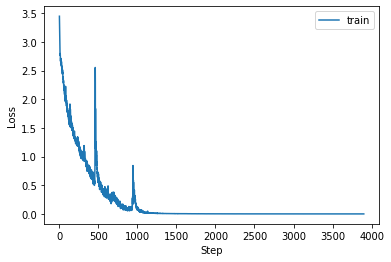

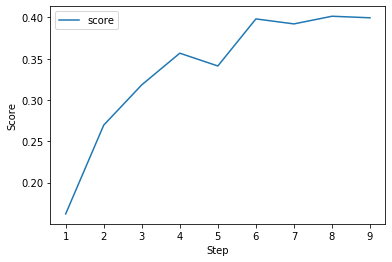

In [11]:
plt.figure()

load = True
if load:
    acc = np.load('loss.npz')
    train_loss = acc['train_loss']
    score = acc['score']

# plt.title("Activation Function comparision(EEGNet)")
plt.ylabel("Loss")
plt.xlabel("Step")
# print(test_loss)
x = np.arange(1, len(train_loss)+1)
plt.plot(x, train_loss, label="train")
# plt.plot(x, test_loss, label="test")
plt.legend()
plt.show()

plt.ylabel("Score")
plt.xlabel("Step")
# print(test_loss)
x = np.arange(1, len(score)+1)
plt.plot(x, score, label="score")
# plt.plot(x, test_loss, label="test")
plt.legend()
plt.show()